## Adaptive optimizers

In this seminar you will implement a logistic regression and train it using stochastic gradient descent modiffications, numpy and your brain.

In [1]:
#load our dakka
import numpy as np
import random
random.seed(42)
np.random.seed(42)
%matplotlib inline
import matplotlib.pyplot as plt

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with syntetic data.

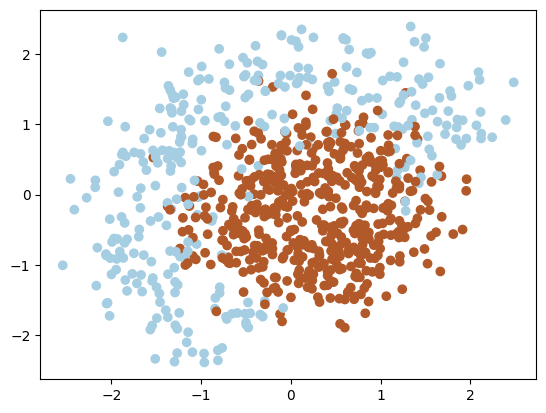

In [2]:
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [3]:
print("X:\n{}\ny:\n{}".format(X[:3],y[:3]))

X:
[[1.20798057 0.0844994 ]
 [0.76121787 0.72510869]
 [0.55256189 0.51937292]]
y:
[1 1 1]


**Your task starts here**

Since the problem above isn't linearly separable, we add quadratic features to the classifier.

Implement this transformation in the __expand__ function __[1 point]__.

In [4]:
def expand(X):
    """
    Adds quadratic features.
    This function allows your linear model to make non-linear separation.

    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature1*feature2, 1]

    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))

    #<your code here>


    X_expanded[:, 0] = X[:, 0]
    X_expanded[:, 1] = X[:, 1]
    X_expanded[:, 2] = X[:, 0]**2
    X_expanded[:, 3] = X[:, 1]**2
    X_expanded[:, 4] = X[:, 0] * X[:, 1]
    X_expanded[:, 5] = 1
    return X_expanded

In [5]:
#simple test on random numbers
#[all 8 random numbers are 100% random :P]
dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

#call your expand function
dummy_expanded = expand(dummy_X)

#what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape==dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")


Seems legit!


### Logistic regression (4 pts)
Now, let's write function that predicts class given X as in logistic regression.

The math should look like this:

$$ P(y| \vec x, \vec w) = \sigma(\vec x \cdot \vec w )$$

where x represents features, w are weights and $$\sigma(a) = {1 \over {1+e^{-a}}}$$

We shall omit $ \vec {arrows} $ in further formulae for simplicity.

In [6]:
def classify(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above

    __don't forget to expand X inside classify and other functions__

    :param X: feature matrix X of shape [n_samples,2] (non-exanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
    X_exp = expand(X)
    return 1.0 / (1.0 + np.exp(-X_exp.dot(w))) #<your code here>

In [7]:
#sample usage / test just as the previous one
dummy_weights = np.linspace(-1,1,6)

dummy_probs = classify(dummy_X,dummy_weights)

dummy_answers = np.array([ 0.73105858,  0.450166  ,  0.02020883,  0.59844257])

assert isinstance(dummy_probs,np.ndarray), "please return np.array"
assert dummy_probs.shape == dummy_answers.shape, "please return an 1-d vector with answers for each object"
assert np.allclose(dummy_probs,dummy_answers,1e-3), "There's something non-canonic about how probabilties are computed"

print("Hooraayyy!!!")

Hooraayyy!!!


The loss you should try to minimize is the Logistic Loss aka crossentropy aka negative log-likelihood:

$$ L =  - {1 \over N} \sum_i {y_i \cdot log P(y_i|x_i,w) + (1-y_i) \cdot log (1-P(y_i|x_i,w))}$$



In [8]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    X_exp = expand(X)
    logits = X_exp.dot(w)
    probs = 1 / (1 + np.exp(-logits))

    epsilon = 1e-15
    probs = np.clip(probs, epsilon, 1 - epsilon)

    log_probs = -y * np.log(probs) - (1 - y) * np.log(1 - probs)
    return log_probs.mean()  #<your code here>


In [9]:
dummy_y = np.array([0,1,0,1])
dummy_loss = compute_loss(dummy_X,dummy_y,dummy_weights)

assert np.allclose(dummy_loss,0.66131), "something wrong with loss"


print("Hooraayyy!!!")

Hooraayyy!!!


Since we train our model with gradient descent, we gotta compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla L = {\partial L \over \partial w} = ...$$

No, we won't be giving you the exact formula this time. Instead, try figuring out a derivative with pen and paper.

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how L changes if you shift w by $10^{-5}$ or so).

In [10]:

def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """

    X_exp = expand(X)
    probs = classify(X, w)
    return X_exp.T.dot(probs - y) / X.shape[0] #<your code here>


In [11]:
#tests
dummy_grads = compute_grad(dummy_X,dummy_y,dummy_weights)

#correct answers in canonic form
dummy_grads_ans = np.array([-0.06504252, -0.21728448, -0.1379879 , -0.43443953,  0.107504  , -0.05003101])

assert isinstance(dummy_grads,np.ndarray)
assert dummy_grads.shape == (6,), "must return a vector of gradients for each weight"
assert len(set(np.round(dummy_grads/dummy_grads_ans,3))), "gradients are wrong"
assert np.allclose(dummy_grads,dummy_grads_ans,1e-3), "gradients are off by a coefficient"

print("Hooraayyy!!!")

Hooraayyy!!!


Here's an auxiliary function that visualizes the predictions

In [12]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.subplot(1,2,2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

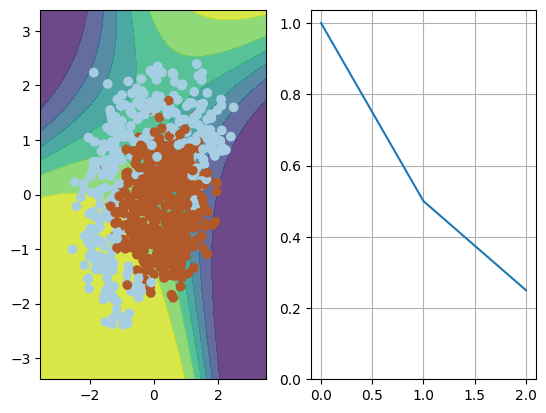

In [13]:
visualize(X,y,dummy_weights,[1,0.5,0.25],)

### Training [1 point]
In this section, we'll use the functions you wrote to train our classifier using stochastic gradient descent.

Try to find an optimal learning rate for gradient descent for the given batch size.

**Don't change the batch size!**

In [14]:


alphas = np.arange(0.01, 1.0, 0.05).tolist()

best_alpha = alphas[0]
best_loss = float('inf')
n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

final_losses = {}
average_losses = {}

for alpha in alphas:
    w = np.array([0, 0, 0, 0, 0, 1])
    loss = np.zeros(n_iter)
    for i in range(n_iter):
        ind = np.random.choice(X.shape[0], batch_size)
        loss[i] = compute_loss(X, y, w)
        #visualize(X[ind,:], y[ind], w, loss)
        w = w - alpha * compute_grad(X[ind,:], y[ind], w)

    average_loss = np.mean(loss)
    final_losses[f"SGD_{alpha}"] = average_loss
    print(f"Alpha: {alpha}, Average Loss: {average_loss}")

    if average_loss < best_loss:
        best_loss = average_loss
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}")


Alpha: 0.01, Average Loss: 0.631443944175381
Alpha: 0.060000000000000005, Average Loss: 0.4857820552087165
Alpha: 0.11, Average Loss: 0.43051904767205534
Alpha: 0.16000000000000003, Average Loss: 0.3943217375049654
Alpha: 0.21000000000000002, Average Loss: 0.39512717461606955
Alpha: 0.26, Average Loss: 0.38766296966433605
Alpha: 0.31000000000000005, Average Loss: 0.3668010329697069
Alpha: 0.36000000000000004, Average Loss: 0.3749167841007887
Alpha: 0.41000000000000003, Average Loss: 0.34354270472899023
Alpha: 0.46, Average Loss: 0.32772092344645093
Alpha: 0.51, Average Loss: 0.3391968641696518
Alpha: 0.56, Average Loss: 0.3252492879346915
Alpha: 0.6100000000000001, Average Loss: 0.3394294662752077
Alpha: 0.66, Average Loss: 0.33120279579421874
Alpha: 0.7100000000000001, Average Loss: 0.3212544767179201
Alpha: 0.76, Average Loss: 0.3065835907479487
Alpha: 0.81, Average Loss: 0.30971241942251515
Alpha: 0.8600000000000001, Average Loss: 0.29894925336115247
Alpha: 0.91, Average Loss: 0.319

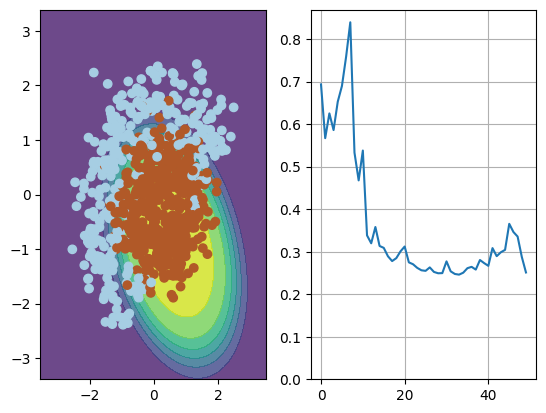

<Figure size 640x480 with 0 Axes>

In [15]:
w = np.array([0, 0, 0, 0, 0, 1])


alpha = float(best_alpha)#<learning rate>

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

visualize(X, y, w, loss)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values. __[2 points]__

In [16]:
w = np.array([0,0,0,0,0,1])
alphas = np.arange(0.01, 1.0, 0.05).tolist()  # Example values
mus = np.arange(0, 1, 0.2).tolist()     # Example momentum values

best_alpha1, best_mu = None, None
best_loss = float('inf')
n_iter = 50
batch_size = 4
for alpha in alphas:
    for mu in mus:
        w = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
        v = np.zeros_like(w)

        loss_history_mu = np.zeros(n_iter)
        for i in range(n_iter):
            ind = np.random.choice(X.shape[0], batch_size)
            gradient = compute_grad(X[ind, :], y[ind], w)
            v = mu * v + alpha * gradient
            w -= v

            loss_history_mu[i] = compute_loss(X, y, w)

        avg_loss = np.mean(loss_history_mu)
        print(f"Alpha: {alpha}, Mu: {mu}, Avg Loss: {avg_loss}")
        final_losses[f"Momentum_{alpha}_{mu}"] = avg_loss  # Storing average loss

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_alpha1, best_mu = alpha, mu

print(f"Best Alpha: {best_alpha1}, Best Mu: {best_mu}")


Alpha: 0.01, Mu: 0.0, Avg Loss: 0.6132902072184919
Alpha: 0.01, Mu: 0.2, Avg Loss: 0.625344890472167
Alpha: 0.01, Mu: 0.4, Avg Loss: 0.5705728914111848
Alpha: 0.01, Mu: 0.6000000000000001, Avg Loss: 0.5512504860249016
Alpha: 0.01, Mu: 0.8, Avg Loss: 0.5014104088310792
Alpha: 0.060000000000000005, Mu: 0.0, Avg Loss: 0.46663103394586697
Alpha: 0.060000000000000005, Mu: 0.2, Avg Loss: 0.4631445764752091
Alpha: 0.060000000000000005, Mu: 0.4, Avg Loss: 0.4431527147879277
Alpha: 0.060000000000000005, Mu: 0.6000000000000001, Avg Loss: 0.41877268247458943
Alpha: 0.060000000000000005, Mu: 0.8, Avg Loss: 0.3824357538213293
Alpha: 0.11, Mu: 0.0, Avg Loss: 0.42648250938555404
Alpha: 0.11, Mu: 0.2, Avg Loss: 0.4083137265855376
Alpha: 0.11, Mu: 0.4, Avg Loss: 0.38445253576565686
Alpha: 0.11, Mu: 0.6000000000000001, Avg Loss: 0.3839881757680532
Alpha: 0.11, Mu: 0.8, Avg Loss: 0.3562901958766307
Alpha: 0.16000000000000003, Mu: 0.0, Avg Loss: 0.39552797683773655
Alpha: 0.16000000000000003, Mu: 0.2, Avg

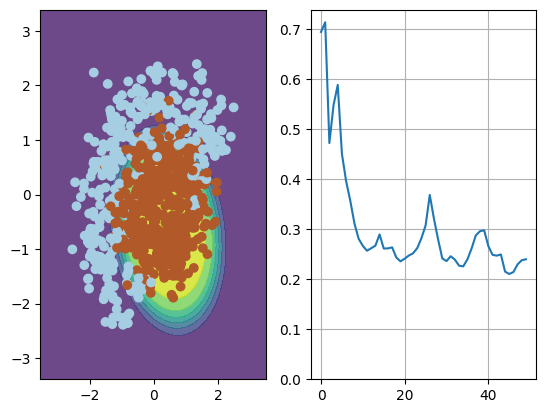

<Figure size 640x480 with 0 Axes>

In [17]:
w = np.array([0.0,0.0,0.0,0.0,0.0,1.0])

alpha = best_alpha1 # learning rate. Please change.
mu    = best_mu # momentum. Please change.

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    #<update w and anything else here>
    gradient = compute_grad(X[ind,:], y[ind], w)
    v = mu * v + alpha * gradient
    w -= v

visualize(X, y, w, loss)
plt.clf()

Implement RMSPROP algorithm __[2 points]__


In [18]:

alpha_values = np.arange(0, 1, 0.2).tolist()
norm_values = np.arange(0.01, 1.0, 0.05).tolist()
epsilon = 1e-8
best_alpha2 = None
best_norm = None
best_loss = float('inf')
n_iter = 50
batch_size = 4
final_losses = {}

for alpha in alpha_values:
    for norm in norm_values:
        w = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
        mean_squared_norm = np.zeros_like(w)  # Initialize with zeros
        loss_rmsprop = np.zeros(n_iter)

        for i in range(n_iter):
            ind = np.random.choice(X.shape[0], batch_size)
            loss_rmsprop[i] = compute_loss(X, y, w)
            gradient = compute_grad(X[ind, :], y[ind], w)
            mean_squared_norm = alpha * mean_squared_norm + (1 - alpha) * gradient ** 2  # Exponential moving average
            w -= norm / (np.sqrt(mean_squared_norm) + epsilon) * gradient  # Using `norm` as learning rate in this context

        final_loss = np.mean(loss_rmsprop)
        print(f"Alpha: {alpha}, Learning Rate (Norm): {norm}, Avg Loss: {final_loss}")
        final_losses[f"RMSPROP_{alpha}_{norm}"] = final_loss
        if final_loss < best_loss:
            best_alpha2 = alpha
            best_norm = norm
            best_loss = final_loss

print(f"Best Decay Factor (Alpha): {best_alpha2}")
print(f"Best Learning Rate (Norm): {best_norm}")





Alpha: 0.01, Learning Rate (Norm): 0.0, Avg Loss: 0.6934069659685858
Alpha: 0.01, Learning Rate (Norm): 0.2, Avg Loss: 0.38231870679528746
Alpha: 0.01, Learning Rate (Norm): 0.4, Avg Loss: 0.37451858422142
Alpha: 0.01, Learning Rate (Norm): 0.6000000000000001, Avg Loss: 0.4011693336257547
Alpha: 0.01, Learning Rate (Norm): 0.8, Avg Loss: 0.6259641061621596
Alpha: 0.060000000000000005, Learning Rate (Norm): 0.0, Avg Loss: 0.6934069659685858
Alpha: 0.060000000000000005, Learning Rate (Norm): 0.2, Avg Loss: 0.33312515586639285
Alpha: 0.060000000000000005, Learning Rate (Norm): 0.4, Avg Loss: 0.48167507706151724
Alpha: 0.060000000000000005, Learning Rate (Norm): 0.6000000000000001, Avg Loss: 0.477315100791629
Alpha: 0.060000000000000005, Learning Rate (Norm): 0.8, Avg Loss: 0.6316532330200534
Alpha: 0.11, Learning Rate (Norm): 0.0, Avg Loss: 0.6934069659685858
Alpha: 0.11, Learning Rate (Norm): 0.2, Avg Loss: 0.3413667809560729
Alpha: 0.11, Learning Rate (Norm): 0.4, Avg Loss: 0.4391212454

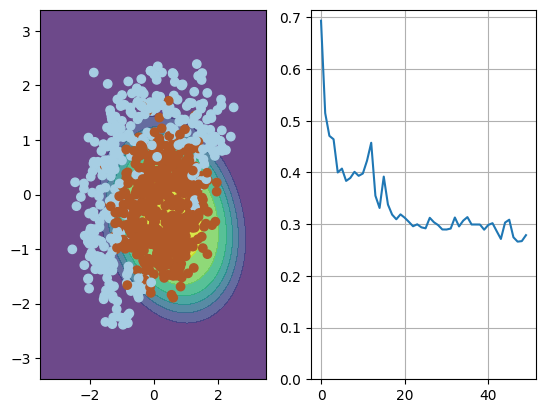

<Figure size 640x480 with 0 Axes>

In [19]:
w = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

alpha = best_alpha2 # learning rate. Please change.
mean_squared_norm = best_norm  # moving average of gradient norm squared. Please change.
epsilon = 1e-8

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind, :], y[ind], w, loss)

    gradient = compute_grad(X[ind, :], y[ind], w)
    mean_squared_norm = mean_squared_norm + (1 - mean_squared_norm) * np.sum(gradient ** 2)  # Exponential moving average
    w -= alpha / (np.sqrt(mean_squared_norm)) * gradient

visualize(X, y, w, loss)
plt.clf()

Which optimization method you consider the best? Type your answer in the cell below

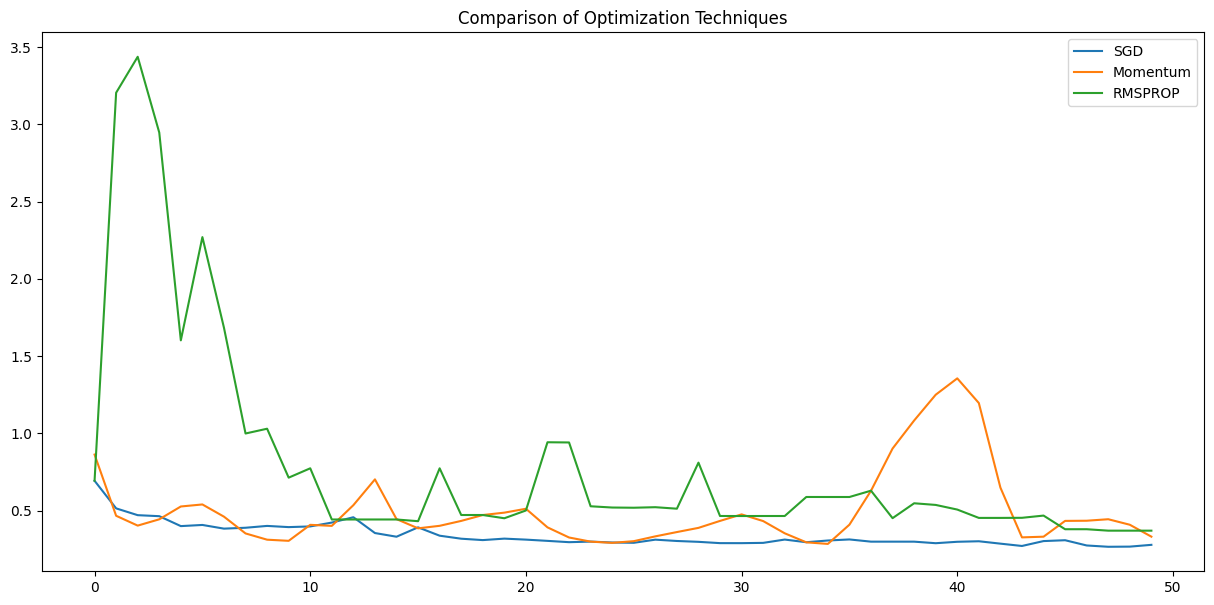

The best optimization technique is: RMSPROP_0.76_0.2 with loss 0.3028689913875634


In [20]:
#best technique from above three is given below!!!!

plt.figure(figsize=(15, 7))
plt.plot(loss, label="SGD")
plt.plot(loss_history_mu, label="Momentum")
plt.plot(loss_rmsprop, label="RMSPROP")
plt.legend()
plt.title("Comparison of Optimization Techniques")
plt.show()
best_technique = min(final_losses, key=final_losses.get)
print(f"The best optimization technique is: {best_technique} with loss {final_losses[best_technique]}")

From the above code cell we find that "RMSPROP_0.76_0.2 with loss 0.3028689913875634" is the best optimization method

# Bonus quest
Try the same thing for Adagrad, Adam and anything else you find suitable.

_Each new adaptive optimizer is worth 2 points!_

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_iter = 50
batch_size = 4
epsilon = 1e-8

# Hyperparameters to search over
alphas = np.arange(0.01, 1.0, 0.05).tolist()
betas1 = np.arange(0.7, 0.95, 0.05).tolist()
betas2 = np.arange(0.8, 0.999, 0.05).tolist()
rhos = np.arange(0.1, 0.95, 0.1).tolist()

final_losses = {}

for alpha in alphas:
    for beta1 in betas1:
        for beta2 in betas2:
            for rho in rhos:

                # Adagrad
                w = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
                G = np.zeros_like(w)
                loss_adagrad = []
                for i in range(n_iter):
                    ind = np.random.choice(X.shape[0], batch_size)
                    current_loss = compute_loss(X, y, w)
                    loss_adagrad.append(current_loss)
                    gradient = compute_grad(X[ind, :], y[ind], w)
                    G += gradient ** 2
                    w -= alpha / (np.sqrt(G) + epsilon) * gradient
                final_losses[f"Adagrad_{alpha}"] = np.mean(loss_adagrad)

                # Adadelta
                w = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
                G = np.zeros_like(w)
                delta = np.zeros_like(w)
                loss_adadelta = []
                for i in range(n_iter):
                    ind = np.random.choice(X.shape[0], batch_size)
                    current_loss = compute_loss(X, y, w)
                    loss_adadelta.append(current_loss)
                    gradient = compute_grad(X[ind, :], y[ind], w)
                    G = rho * G + (1 - rho) * gradient ** 2
                    step = - np.sqrt(delta + epsilon) / np.sqrt(G + epsilon) * gradient
                    w += step
                    delta = rho * delta + (1 - rho) * step ** 2
                final_losses[f"Adadelta_{alpha}_{rho}"] = np.mean(loss_adadelta)


                # Adam
                w = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
                m = np.zeros_like(w)
                v = np.zeros_like(w)
                loss_adam = []
                for i in range(n_iter):
                    ind = np.random.choice(X.shape[0], batch_size)
                    current_loss = compute_loss(X, y, w)
                    loss_adam.append(current_loss)
                    gradient = compute_grad(X[ind, :], y[ind], w)
                    m = beta1 * m + (1 - beta1) * gradient
                    v = beta2 * v + (1 - beta2) * gradient ** 2
                    m_corr = m / (1 - beta1 ** (i + 1))
                    v_corr = v / (1 - beta2 ** (i + 1))
                    w -= alpha * m_corr / (np.sqrt(v_corr) + epsilon)
                final_losses[f"Adam_{alpha}"] = loss_adam[-1]

                # Adamax based on infinity norm
                w = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
                m = np.zeros_like(w)
                u = np.zeros_like(w)
                loss_adamax = []
                for i in range(n_iter):
                    ind = np.random.choice(X.shape[0], batch_size)
                    current_loss = compute_loss(X, y, w)
                    loss_adamax.append(current_loss)
                    gradient = compute_grad(X[ind, :], y[ind], w)
                    m = beta1 * m + (1 - beta1) * gradient
                    u = np.maximum(beta2 * u, np.abs(gradient))
                    w -= alpha / (1 - beta1 ** (i + 1)) * m / u
                final_losses[f"Adamax_{alpha}"] = loss_adamax[-1]

                # RAdam (simplified without full bias correction)
                w = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
                m = np.zeros_like(w)
                v = np.zeros_like(w)
                loss_radam = []
                for i in range(n_iter):
                    ind = np.random.choice(X.shape[0], batch_size)
                    current_loss = compute_loss(X, y, w)
                    loss_radam.append(current_loss)
                    gradient = compute_grad(X[ind, :], y[ind], w)
                    m = beta1 * m + (1 - beta1) * gradient
                    v = beta2 * v + (1 - beta2) * gradient ** 2
                    rho_inf = 2 / (1 - beta2) - 1
                    rho_t = rho_inf - 2 * (i + 1) * beta2 ** (i + 1) / (1 - beta2 ** (i + 1))
                    if rho_t > 4:
                        r_t = np.sqrt((rho_t - 4) * (rho_t - 2) * rho_inf / ((rho_inf - 4) * (rho_inf - 2) * rho_t))
                        w -= alpha * r_t * m / (np.sqrt(v) + epsilon)
                    else:
                        w -= alpha * m
                final_losses[f"RAdam_{alpha}"] = loss_radam[-1]



In [22]:
best_technique = min(final_losses, key=final_losses.get)
print(f"The best optimization technique is: {best_technique} with loss {final_losses[best_technique]}")

The best optimization technique is: Adamax_0.7100000000000001 with loss 0.21057439351882334


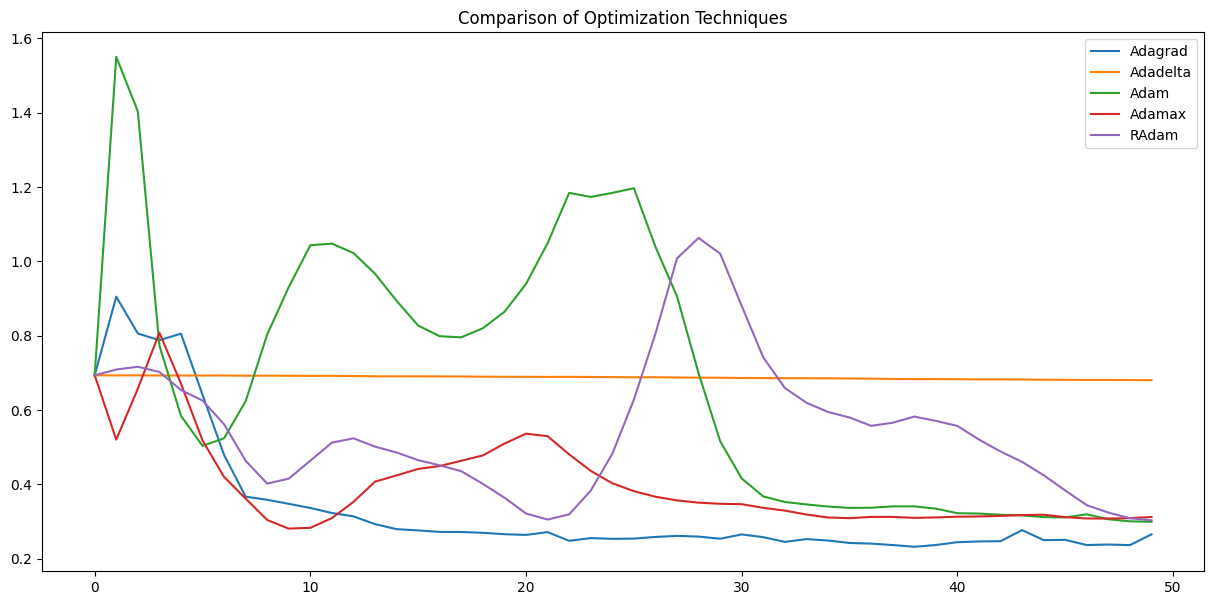

In [23]:
plt.figure(figsize=(15, 7))
plt.plot(loss_adagrad, label="Adagrad")
plt.plot(loss_adadelta, label="Adadelta")
plt.plot(loss_adam, label="Adam")
plt.plot(loss_adamax, label="Adamax")
plt.plot(loss_radam, label="RAdam")
plt.legend()
plt.title("Comparison of Optimization Techniques")
plt.show()